In [11]:
!pip install sdv

### Load dataset

In [23]:
from sdv.demo import load_tabular_demo
import pandas as pd

data = pd.read_csv('data/infringement_dataset_v2.csv')
data.head()


,loan_id,infringed,contract_type,gender,has_own_car,has_own_realty,num_children,annual_income,credit_amount,credit_annuity,...,first_name,last_name,past_avg_amount_annuity,past_avg_amt_application,past_avg_amt_credit,past_loans_approved,past_loans_refused,past_loans_canceled,past_loans_unused,past_loans_total
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,Robert,Watkins,9251.775,179055.00,179055.00,1.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Jane,Navarro,56553.990,435436.50,484191.00,3.0,0.0,0.0,0.0,3.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,David,Seagraves,5357.250,24282.00,20106.00,1.0,0.0,0.0,0.0,1.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,Deborah,Tandy,23651.175,272203.26,291695.50,5.0,3.0,1.0,0.0,9.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,David,Walker,12278.805,150530.25,166638.75,6.0,0.0,0.0,0.0,6.0


### Fit CTGAN to the data (train the model)
CTGAN paper: https://arxiv.org/pdf/1907.00503.pdf

In [59]:
import warnings
warnings.filterwarnings('ignore')

from sdv.tabular import GaussianCopula

model = GaussianCopula(
                    primary_key='loan_id', 
                    anonymize_fields={
                        'loan_id': 'loan_id',
                        'first_name': 'first_name',
                        'last_name': 'last_name'
                    })
model.fit(data)


### Create synthetic samples using the trained model

In [61]:
new_data = model.sample(num_rows=307511)
new_data.head(5)

new_data.to_csv("Synthetic_data.csv", index=False)

### Evaluate synthetic data

In [62]:
from sdv.evaluation import evaluate
overall_score = evaluate(new_data, data)
overall_score

0.8635567324516418

### Quality report

In [63]:
from sdmetrics.reports.single_table import QualityReport
my_report = QualityReport()
my_report.generate(data, new_data, model.get_metadata().to_dict())


Creating report: 100%|██████████| 4/4 [25:13<00:00, 378.45s/it]



Overall Quality Score: 86.92%

Properties:
Column Shapes: 84.96%
Column Pair Trends: 88.87%


### Column comparison

In [64]:
my_report.get_details(property_name='Column Shapes')

,Column,Metric,Quality Score
0,infringed,KSComplement,0.980619
1,num_children,KSComplement,0.751684
2,annual_income,KSComplement,0.677494
3,credit_amount,KSComplement,0.858203
4,credit_annuity,KSComplement,0.937471
5,goods_valuation,KSComplement,0.864631
6,age,KSComplement,0.977071
7,days_employed,KSComplement,0.261158
8,car_age,KSComplement,0.914369
9,provided_mobilephone,KSComplement,0.999997


### Correlation pairs

In [69]:
my_report.get_visualization(property_name='Column Pair Trends')

### Distribution comparison

In [66]:
from sdmetrics.reports.utils import get_column_plot

fig = get_column_plot(
    real_data=data,
    synthetic_data=new_data,
    metadata=model.get_metadata().to_dict(),
    column_name='age'
)

fig.show()

In [68]:
from sdmetrics.reports.utils import get_column_plot

fig = get_column_plot(
    real_data=data,
    synthetic_data=new_data,
    metadata=model.get_metadata().to_dict(),
    column_name='infringed'
)

fig.show()

In [73]:
aux = pd.read_csv('Synthetic_data.csv')
columns = ['age', 'past_avg_amount_annuity', 'past_avg_amt_application', 'past_avg_amt_credit', 'past_loans_total']
colunas = aux[columns]
groupby_age = colunas.groupby("age").mean()
display(groupby_age)

,past_avg_amount_annuity,past_avg_amt_application,past_avg_amt_credit,past_loans_total
age,,,,
20,11375.723518,125801.235135,136341.295270,4.881757
21,12315.692806,135490.925448,148847.362064,5.071721
22,12476.718195,135553.600629,149373.879360,5.021441
23,12792.959396,142666.933281,157860.510812,5.123945
24,12757.517544,142146.267196,156131.312244,5.148148
25,12950.017715,146418.425081,161157.716459,5.154485
26,13025.523800,148221.473596,163816.649760,5.142768
27,13158.883184,149561.097222,164641.221059,5.133078
28,13191.384189,149657.026049,166026.212706,5.247376


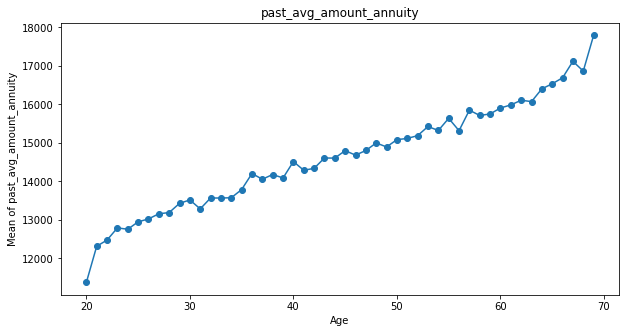

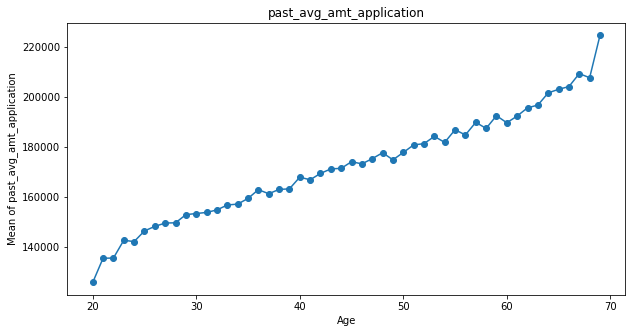

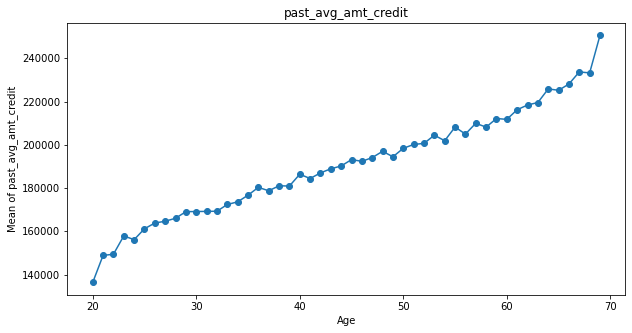

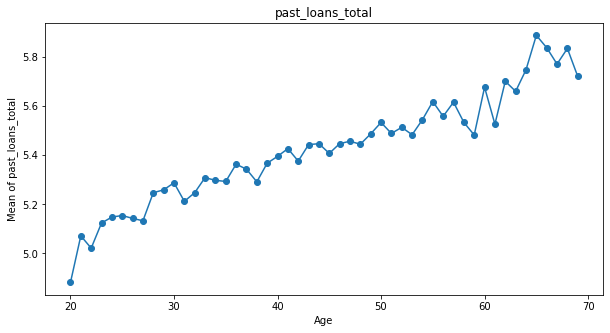

In [75]:
from matplotlib import pyplot as plt
import numpy as np
def plot(column, x, y):   
    plt.figure(figsize=(10,5))
    plt.title(column)
    plt.xlabel("Age")
    plt.ylabel("Mean of " + column)
    plt.plot(x, y)
    plt.scatter(x, y)

x = np.arange(20,70)
plot('past_avg_amount_annuity', x, groupby_age['past_avg_amount_annuity'])
plot('past_avg_amt_application', x, groupby_age['past_avg_amt_application'])
plot('past_avg_amt_credit', x, groupby_age['past_avg_amt_credit'])
plot('past_loans_total', x, groupby_age['past_loans_total'])

<AxesSubplot:title={'center':'Percentagem de clientes com determinada idade com empréstimos em incumprimento'}, xlabel='age', ylabel='Percentagem de empréstimos em incumprimento'>

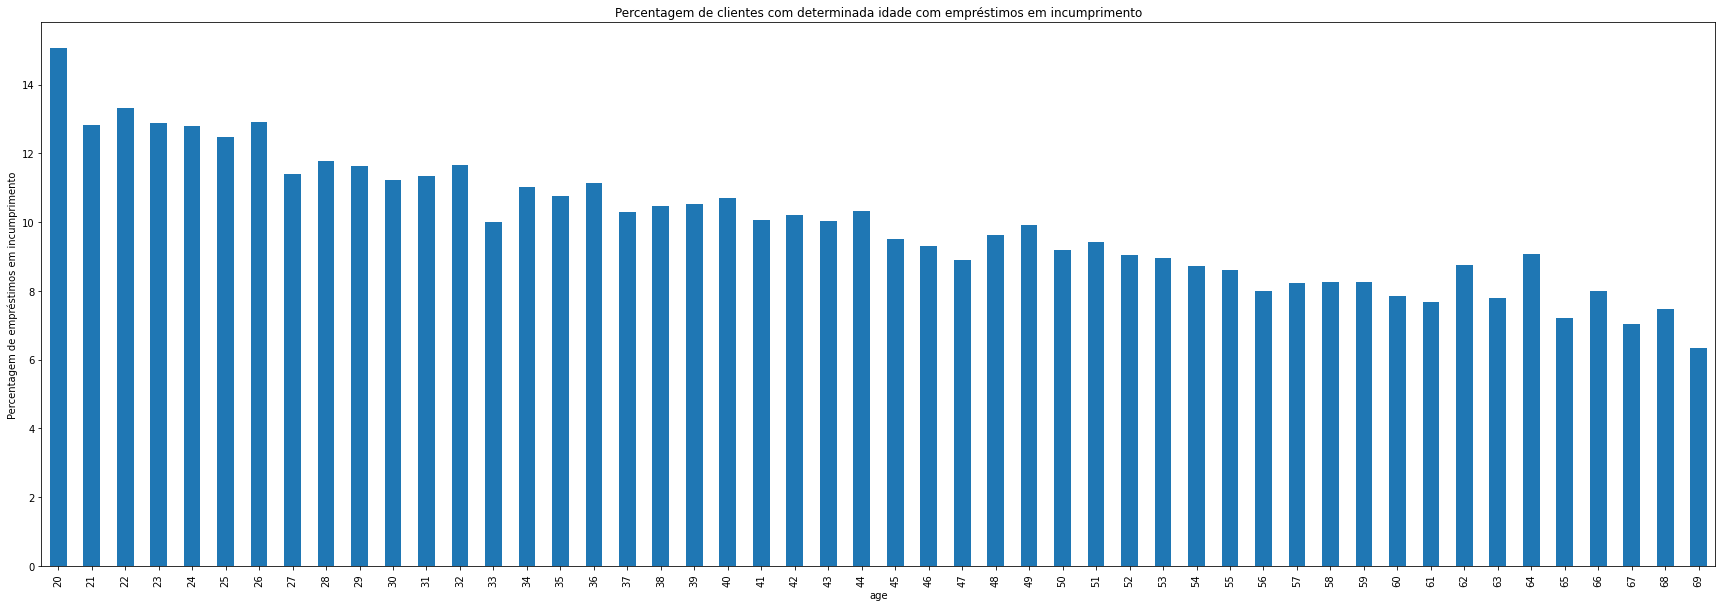

In [76]:
count_inf = aux[aux['infringed']==1.0].groupby(['age']).size()

age = aux.groupby(['age']).size()


plt.title("Percentagem de clientes com determinada idade com empréstimos em incumprimento")
plt.xlabel("Idade dos clientes")
plt.ylabel("Percentagem de empréstimos em incumprimento")

((count_inf/age)*100).plot(figsize=(30,10), kind='bar')